In [1]:
import xarray as xr
import numpy as np

In [2]:
st = xr.open_dataset('stl1_subset_5x5deg.nc')
sm = xr.open_dataset('swvl1_subset_5x5deg.nc')

gpp = xr.open_dataset('gross_primary_productivity_subset_5x5deg.nc')

In [3]:
st = st.stl1
sm = sm.swvl1

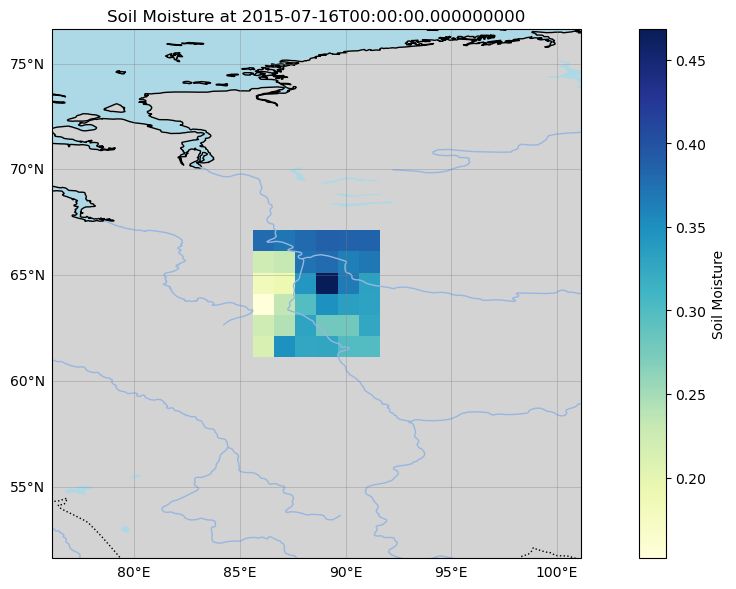

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Select one time slice
da = sm.isel(time=300)

# Ensure lat/lon are coords
if 'lat' not in da.coords or 'lon' not in da.coords:
    da = da.assign_coords(lat=sm['lat'], lon=sm['lon'])

# Get actual data bounds
lat_min = float(da['lat'].min())
lat_max = float(da['lat'].max())
lon_min = float(da['lon'].min())
lon_max = float(da['lon'].max())

# Set up the map with PlateCarree
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add background features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS)

# Plot data
im = ax.pcolormesh(
    da['lon'], da['lat'], da,
    transform=ccrs.PlateCarree(),
    cmap='YlGnBu'
)

# Set extent a bit wider than data bounds for context
pad = 10  # degree padding around your domain
ax.set_extent([lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad], crs=ccrs.PlateCarree())

# Gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Colorbar and title
plt.colorbar(im, ax=ax, orientation='vertical', label='Soil Moisture')
ax.set_title(f'Soil Moisture at {str(da["time"].values)}')
plt.tight_layout()
plt.show()


In [5]:
import xarray as xr
import numpy as np

def detect_compound_events(sm: xr.DataArray, st: xr.DataArray, window=1, sm_q=0.1, st_q=0.9):
    """
    Detect compound dry-hot events where:
    - Soil moisture is below the `sm_q` percentile
    - Soil temperature is above the `st_q` percentile
    - Based on a ±window step-of-year rolling climatology (e.g. window=1 uses steps [i-1, i, i+1])

    Parameters:
        sm (xr.DataArray): Soil moisture with dimensions (time, lat, lon)
        st (xr.DataArray): Soil temperature with same dimensions
        window (int): Number of neighboring time steps to include on each side (±window)
        sm_q (float): Percentile threshold for dry (default: 0.1 = 10th percentile)
        st_q (float): Percentile threshold for hot (default: 0.9 = 90th percentile)

    Returns:
        compound (xr.DataArray): Boolean array of shape (time, lat, lon) where compound events occur
    """
    # Basic checks
    assert sm.shape == st.shape, "Input DataArrays must have the same shape"
    assert 'time' in sm.dims and 'lat' in sm.dims and 'lon' in sm.dims, "Expected (time, lat, lon) dims"

    # Calculate step-of-year index (timestep index within each year)
    step_index = (
        sm['time'].to_index()
        .to_series()
        .groupby(sm['time'].dt.year.values)
        .cumcount()
        .to_numpy()
    )

    # Convert to DataArray
    step_of_year = xr.DataArray(step_index, dims='time', coords={'time': sm['time']})

    # Assign as coordinate (IMPORTANT: use .data to avoid ambiguity)
    sm = sm.assign_coords(step_of_year=('time', step_of_year.data))
    st = st.assign_coords(step_of_year=('time', step_of_year.data))



    n_steps = int(sm['step_of_year'].max().values) + 1
    n_time = sm.sizes['time']

    # Pre-allocate threshold arrays
    sm_thresh = xr.full_like(sm, np.nan)
    st_thresh = xr.full_like(st, np.nan)

    # Loop over time steps
    for t_idx in range(n_time):
        current_step = sm['step_of_year'][t_idx].values
        # Rolling window: wrap around end/beginning
        window_steps = [(current_step + i) % n_steps for i in range(-window, window + 1)]

        mask = sm['step_of_year'].isin(window_steps)
        sm_window = sm.where(mask, drop=True)
        st_window = st.where(mask, drop=True)

        # Calculate percentiles across matching time steps
        sm_thresh[t_idx] = sm_window.quantile(sm_q, dim='time', skipna=True)
        st_thresh[t_idx] = st_window.quantile(st_q, dim='time', skipna=True)

    # Identify compound events
    compound = (sm < sm_thresh) & (st > st_thresh)

    # Print stats
    total_events = int(compound.sum().values)
    total_timesteps = compound.sizes['time']
    n_cells = compound.sizes['lat'] * compound.sizes['lon']
    print(f"\n✅ Compound event detection complete!")
    print(f"→ Total compound events found: {total_events}")
    print(f"→ Average events per timestep: {total_events / total_timesteps:.2f}")
    print(f"→ Average events per grid cell: {total_events / n_cells:.2f}")

    return compound


In [40]:
from scipy.stats import percentileofscore

def detect_compound_events_percentile(sm: xr.DataArray, st: xr.DataArray, window=1, sm_q=0.1, st_q=0.9):
    """
    Detect compound dry-hot events and return a dataset with event mask,
    soil moisture percentile, and soil temperature percentile.
    """
    assert sm.shape == st.shape, "Input DataArrays must have the same shape"
    assert 'time' in sm.dims and 'lat' in sm.dims and 'lon' in sm.dims, "Expected (time, lat, lon) dims"

    step_index = (
        sm['time'].to_index()
        .to_series()
        .groupby(sm['time'].dt.year.values)
        .cumcount()
        .to_numpy()
    )
    step_of_year = xr.DataArray(step_index, dims='time', coords={'time': sm['time']})
    sm = sm.assign_coords(step_of_year=('time', step_of_year.data))
    st = st.assign_coords(step_of_year=('time', step_of_year.data))

    n_steps = int(sm['step_of_year'].max().values) + 1
    n_time = sm.sizes['time']

    sm_thresh = xr.full_like(sm, np.nan)
    st_thresh = xr.full_like(st, np.nan)
    sm_percentile = xr.full_like(sm, np.nan)
    st_percentile = xr.full_like(st, np.nan)

    for t_idx in range(n_time):
        current_step = sm['step_of_year'][t_idx].values
        window_steps = [(current_step + i) % n_steps for i in range(-window, window + 1)]
        mask = sm['step_of_year'].isin(window_steps)
        sm_window = sm.where(mask, drop=True)
        st_window = st.where(mask, drop=True)
        sm_thresh[t_idx] = sm_window.quantile(sm_q, dim='time', skipna=True)
        st_thresh[t_idx] = st_window.quantile(st_q, dim='time', skipna=True)

        for i in range(sm.sizes['lat']):
            for j in range(sm.sizes['lon']):
                if np.isnan(sm[t_idx, i, j]) or np.isnan(st[t_idx, i, j]):
                    continue
                # Soil moisture percentile
                sm_vals = sm_window[:, i, j].values
                sm_val = sm[t_idx, i, j].values
                if np.isfinite(sm_val) and np.any(np.isfinite(sm_vals)):
                    sm_percentile[t_idx, i, j] = percentileofscore(sm_vals[~np.isnan(sm_vals)], sm_val, kind='rank') / 100.0
                # Soil temperature percentile
                st_vals = st_window[:, i, j].values
                st_val = st[t_idx, i, j].values
                if np.isfinite(st_val) and np.any(np.isfinite(st_vals)):
                    st_percentile[t_idx, i, j] = percentileofscore(st_vals[~np.isnan(st_vals)], st_val, kind='rank') / 100.0

    compound = (sm < sm_thresh) & (st > st_thresh)

    # Print stats
    total_events = int(compound.sum().values)
    total_timesteps = compound.sizes['time']
    n_cells = compound.sizes['lat'] * compound.sizes['lon']
    print(f"\n✅ Compound event detection complete!")
    print(f"→ Total compound events found: {total_events}")
    print(f"→ Average events per timestep: {total_events / total_timesteps:.2f}")
    print(f"→ Average events per grid cell: {total_events / n_cells:.2f}")

    return xr.Dataset({
        'compound': compound,
        'sm_percentile': sm_percentile,
        'st_percentile': st_percentile
    })


In [41]:
compound_events_percentile = detect_compound_events_percentile(sm, st, window=1, sm_q=0.1, st_q=0.9)

c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarnin


✅ Compound event detection complete!
→ Total compound events found: 256
→ Average events per timestep: 0.56
→ Average events per grid cell: 7.11


c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
c:\Users\bjoer\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1563: RuntimeWarnin

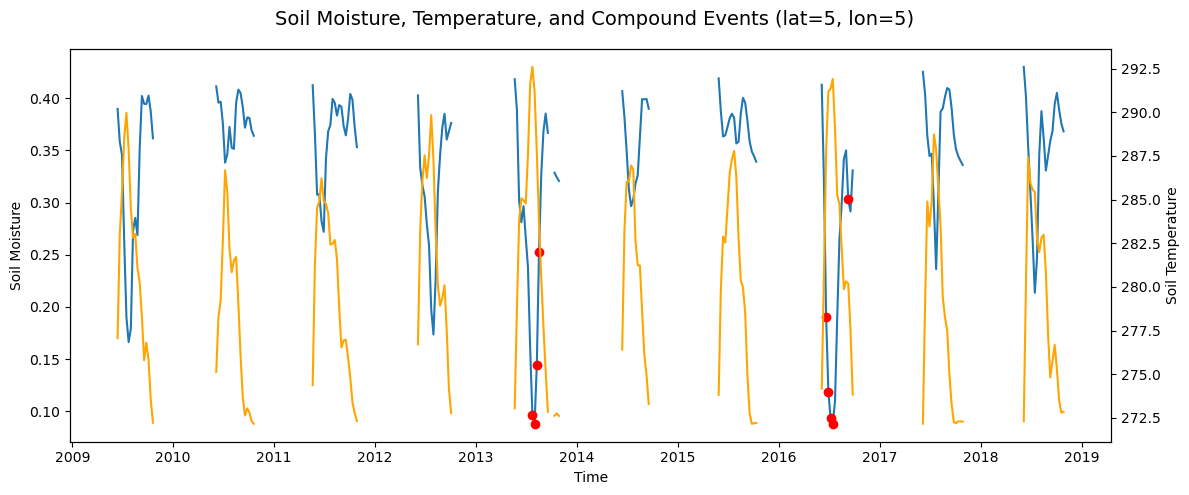

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Extract time series for the grid cell (5,5)
sm_point = sm.isel(lat=5, lon=5)
st_point = st.isel(lat=5, lon=5)
time = sm.time

# Use the compound DataArray directly for this cell
compound_markers = compound.isel(lat=5, lon=5)

# Plot soil moisture
ax1.set_xlabel('Time')
ax1.set_ylabel('Soil Moisture')
ax1.plot(time.values, sm_point.values, label='Soil Moisture')
ax1.tick_params(axis='y')

# Compound event markers
ax1.scatter(time.values[compound_markers.values], sm_point.values[compound_markers.values],
            color='red', label='Compound Event', zorder=5)

# Plot soil temperature on secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel('Soil Temperature')
ax2.plot(time.values, st_point.values, label='Soil Temperature', color='orange')
ax2.tick_params(axis='y')

fig.suptitle('Soil Moisture, Temperature, and Compound Events (lat=5, lon=5)', fontsize=14)
fig.tight_layout()
plt.show()


In [11]:
gpp = gpp.gross_primary_productivity

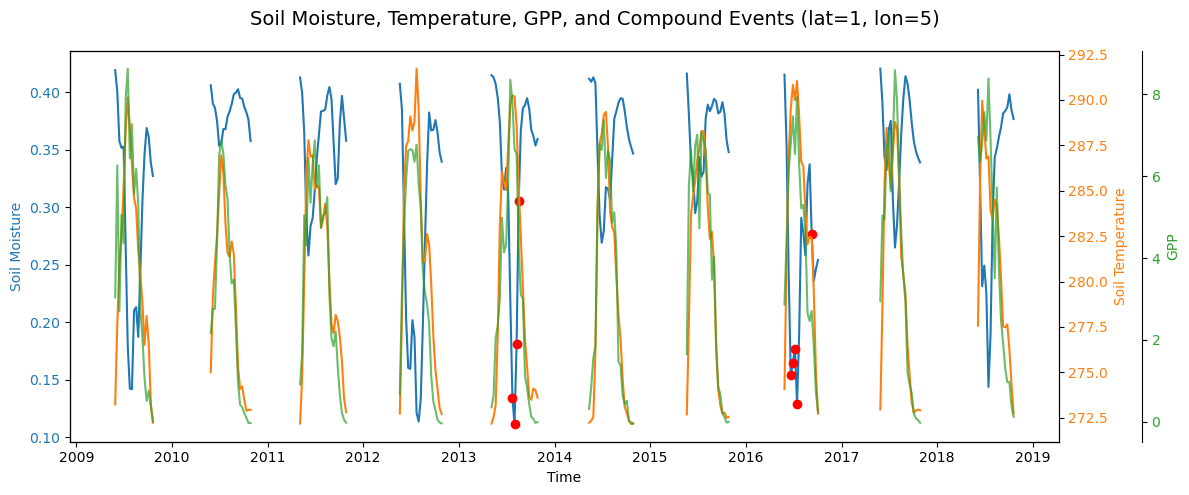

In [17]:
import random

color1 = 'tab:blue'
color2 = 'tab:orange'

lat = random.randint(1, 5)
lon = random.randint(1, 5)

fig, ax1 = plt.subplots(figsize=(12, 5))

# Extract time series for the grid cell (5,5)
sm_point = sm.isel(lat=lat, lon=lon)
st_point = st.isel(lat=lat, lon=lon)
# gpp_point = gpp.isel(lat, lon)  # <-- This is incorrect usage and should be removed
compound_markers = compound.isel(lat=lat, lon=lon)
gpp_point = gpp.isel(lat=lat, lon=lon)
time = sm.time

# Use the compound DataArray directly for this cell
compound_markers = compound.isel(lat=5, lon=5)

# Plot soil moisture
ax1.set_xlabel('Time')
ax1.set_ylabel('Soil Moisture', color=color1)
ax1.plot(time.values, sm_point.values, label='Soil Moisture', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Compound event markers
ax1.scatter(time.values[compound_markers.values], sm_point.values[compound_markers.values],
            color='red', label='Compound Event', zorder=5)

# Plot soil temperature on secondary axis
ax2 = ax1.twinx()
ax2.set_ylabel('Soil Temperature', color=color2)
ax2.plot(time.values, st_point.values, label='Soil Temperature', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Plot GPP on a third axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('GPP', color='tab:green')
ax3.plot(time.values, gpp_point.values, label='GPP', color='tab:green', alpha=0.7)
ax3.tick_params(axis='y', labelcolor='tab:green')

fig.suptitle(f'Soil Moisture, Temperature, GPP, and Compound Events (lat={lat}, lon={lon})', fontsize=14)
fig.tight_layout()
plt.show()

In [47]:
def calculate_compound_event_metrics_yearly(compound_ds, time_coord='time'):
    """
    Calculate duration, peak intensity, severity, and frequency for compound events, yearly.
    Returns: xr.Dataset with dims (year, lat, lon) and metrics as DataArrays.
    """
    times = compound_ds[time_coord].values
    years = pd.to_datetime(times).year
    year_list = np.unique(years)
    lat_vals = compound_ds.lat.values
    lon_vals = compound_ds.lon.values

    # Prepare output arrays
    shape = (len(year_list), len(lat_vals), len(lon_vals))
    duration_mean = np.full(shape, np.nan)
    duration_max = np.full(shape, np.nan)
    peak_intensity_mean = np.full(shape, np.nan)
    peak_intensity_max = np.full(shape, np.nan)
    severity_mean = np.full(shape, np.nan)
    severity_max = np.full(shape, np.nan)
    frequency_per_year = np.full(shape, np.nan)

    for yi, year in enumerate(year_list):
        year_mask = (years == year)
        for i, lat_val in enumerate(lat_vals):
            for j, lon_val in enumerate(lon_vals):
                mask = compound_ds['compound'][year_mask, i, j].values
                sm_p = compound_ds['sm_percentile'][year_mask, i, j].values
                st_p = compound_ds['st_percentile'][year_mask, i, j].values

                # Find contiguous events
                event_id = (mask.astype(int) * (np.diff(np.concatenate(([0], mask.astype(int)))) != 0).cumsum())
                event_id[~mask] = 0
                unique_events = np.unique(event_id[event_id > 0])

                durations = []
                peak_intensities = []
                severities = []

                for eid in unique_events:
                    idx = np.where(event_id == eid)[0]
                    if len(idx) == 0:
                        continue
                    duration = len(idx)
                    st_dev = st_p[idx] - 0.9
                    sm_dev = 0.1 - sm_p[idx]
                    peak_intensity = np.nanmax(np.abs(st_dev) + np.abs(sm_dev))
                    severity = np.nansum(np.abs(st_dev) + np.abs(sm_dev))

                    durations.append(duration)
                    peak_intensities.append(peak_intensity)
                    severities.append(severity)

                # Fill output arrays
                duration_mean[yi, i, j] = np.mean(durations) if durations else 0
                duration_max[yi, i, j] = np.max(durations) if durations else 0
                peak_intensity_mean[yi, i, j] = np.mean(peak_intensities) if peak_intensities else 0
                peak_intensity_max[yi, i, j] = np.max(peak_intensities) if peak_intensities else 0
                severity_mean[yi, i, j] = np.mean(severities) if severities else 0
                severity_max[yi, i, j] = np.max(severities) if severities else 0
                frequency_per_year[yi, i, j] = len(durations)

    ds = xr.Dataset(
        {
            'duration_mean': (('year', 'lat', 'lon'), duration_mean),
            'duration_max': (('year', 'lat', 'lon'), duration_max),
            'peak_intensity_mean': (('year', 'lat', 'lon'), peak_intensity_mean),
            'peak_intensity_max': (('year', 'lat', 'lon'), peak_intensity_max),
            'severity_mean': (('year', 'lat', 'lon'), severity_mean),
            'severity_max': (('year', 'lat', 'lon'), severity_max),
            'frequency_per_year': (('year', 'lat', 'lon'), frequency_per_year),
        },
        coords={
            'year': year_list,
            'lat': lat_vals,
            'lon': lon_vals
        }
    )
    return ds



In [ ]:

compound_metrics = calculate_compound_event_metrics_yearly(compound_events_percentile)

In [72]:
import pandas as pd
from scipy.ndimage import label

def extract_event_summaries(compound_ds, gpp, baseline='outside'):
    """
    Extract event-level summaries for each contiguous compound event in each grid cell.
    Returns a DataFrame with one row per event, including GPP anomaly
    (anomaly is computed relative to the same time index across all years).
    """

    compound = compound_ds['compound'].values
    sm_percentile = compound_ds['sm_percentile'].values
    st_percentile = compound_ds['st_percentile'].values
    times = compound_ds['time'].values
    lats = compound_ds['lat'].values
    lons = compound_ds['lon'].values

    # Compute step-of-year for each time index
    step_of_year = pd.Series(pd.to_datetime(times)).groupby(pd.to_datetime(times).year).cumcount().values

    # Compute seasonal climatology: mean GPP for each step-of-year, lat, lon
    gpp_steps = xr.DataArray(step_of_year, dims='time', coords={'time': times})
    gpp_with_step = gpp.assign_coords(step_of_year=('time', gpp_steps.data))
    gpp_clim = gpp_with_step.groupby('step_of_year').mean(dim='time')

    event_rows = []
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            mask_1d = compound[:, i, j]
            labeled, n_events = label(mask_1d)
            for event_id in range(1, n_events + 1):
                idx = np.where(labeled == event_id)[0]
                if len(idx) == 0:
                    continue
                start_idx, end_idx = idx[0], idx[-1]
                start_time = times[start_idx]
                end_time = times[end_idx]
                duration = end_idx - start_idx + 1

                sm_p = sm_percentile[idx, i, j]
                st_p = st_percentile[idx, i, j]
                st_dev = st_p - 0.9
                sm_dev = 0.1 - sm_p
                intensity = np.nanmax(np.abs(st_dev) + np.abs(sm_dev))
                severity = np.nansum(np.abs(st_dev) + np.abs(sm_dev))

                # GPP anomaly relative to seasonal climatology
                gpp_event = gpp[:, i, j].values[idx]
                steps_idx = step_of_year[idx]
                gpp_clim_event = gpp_clim[:, i, j].values[steps_idx]
                gpp_anomaly = np.nanmean(gpp_event - gpp_clim_event)
                gpp_mean = np.nanmean(gpp_event)
                gpp_base = np.nanmean(gpp_clim_event)

                event_rows.append({
                    'lat': lat,
                    'lon': lon,
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': duration,
                    'severity': severity,
                    'intensity': intensity,
                    'gpp_mean': gpp_mean,
                    'gpp_baseline': gpp_base,
                    'gpp_anomaly': gpp_anomaly,
                    'event_indices': idx
                })

    event_df = pd.DataFrame(event_rows)
    return event_df


In [73]:
event_summary_df = extract_event_summaries(compound_events_percentile, gpp)
event_summary_df

,lat,lon,start_time,end_time,duration,severity,intensity,gpp_mean,gpp_baseline,gpp_anomaly,event_indices
0,61.625,86.125,2012-06-05,2012-06-13,2,0.200000,0.133333,6.482503,5.235344,1.247159,"[157, 158]"
1,61.625,86.125,2012-07-23,2012-07-23,1,0.166667,0.166667,7.150129,6.941831,0.208298,[163]
2,61.625,87.125,2011-05-05,2011-05-05,1,0.066667,0.066667,1.868734,1.516407,0.352327,[107]
3,61.625,87.125,2012-07-23,2012-07-23,1,0.166667,0.166667,7.849910,7.343877,0.506032,[163]
4,61.625,87.125,2016-09-17,2016-09-17,1,0.066667,0.066667,2.889304,1.873994,1.015310,[354]
...,...,...,...,...,...,...,...,...,...,...,...
140,66.625,90.125,2016-06-21,2016-07-15,4,0.400000,0.133333,4.347814,3.691646,0.656167,"[343, 344, 345, 346]"
141,66.625,90.125,2016-09-09,2016-09-09,1,0.100000,0.100000,0.994007,0.519744,0.474263,[353]
142,66.625,91.125,2013-07-24,2013-08-17,4,0.366667,0.133333,4.188869,3.735392,0.453478,"[209, 210, 211, 212]"
143,66.625,91.125,2016-06-21,2016-07-15,4,0.400000,0.133333,4.343885,4.154310,0.189575,"[343, 344, 345, 346]"


In [ ]:
event_summary_df.gpp_anomaly

count    145.000000
mean       0.931470
std        0.459231
min       -0.075681
25%        0.583693
50%        0.914743
75%        1.198994
max        2.333045
Name: gpp_anomaly, dtype: float64